In [3]:
# Importing modules

import tensorflow as tf
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [4]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Lambda, Dropout
from keras.layers.convolutional import Convolution2D, Convolution1D
from keras.layers.pooling import MaxPooling2D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Cropping2D, Cropping1D

Using TensorFlow backend.


In [16]:
import csv
from sklearn.utils import shuffle

In [5]:
def normalize(image):
    return (image/255 - 0.5)

def blur(img, kernel_size):
    return cv2.blur(img, (kernel_size, kernel_size))

def hsv(image):
    image = cv2.resize(image, (80,40))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    image = image[15:40, 0:80]
    #print (image.shape)
    return image

def process_image(image):
    image = normalize(blur(hsv(image)[:,:,1], kernel_size=5))
    return image

## Sample Images

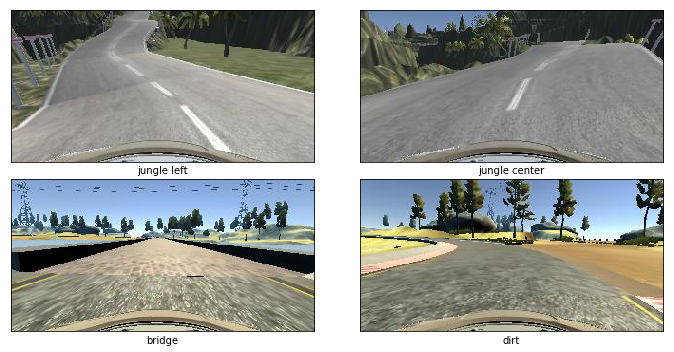

In [104]:
img1 = mpimg.imread('./training/IMG/center_2017_03_01_14_54_51_349.jpg')
img2 = mpimg.imread('./training/IMG/center_2017_03_01_14_54_52_859.jpg')
img3 = mpimg.imread('./training/IMG/center_2017_03_01_14_40_23_382.jpg')
img4 = mpimg.imread('./training/IMG/center_2017_03_02_17_33_25_470.jpg')

fig = plt.figure(figsize=(10,5))
axes = []

axis = fig.add_subplot(2,2,1)
axis.set_xlabel('jungle left')
plt.xticks(np.array([]))
plt.yticks(np.array([]))
axis.imshow(img1)

axis = fig.add_subplot(2,2,2)
axis.set_xlabel('jungle center')
plt.xticks(np.array([]))
plt.yticks(np.array([]))
axis.imshow(img2)

axis = fig.add_subplot(2,2,3)
axis.set_xlabel('bridge')
plt.xticks(np.array([]))
plt.yticks(np.array([]))
axis.imshow(img3)

axis = fig.add_subplot(2,2,4)
axis.set_xlabel('dirt')
plt.xticks(np.array([]))
plt.yticks(np.array([]))
axis.imshow(img4)

plt.tight_layout(h_pad=0, w_pad=0)
plt.show()


## Pre-processed Images (Resized, Cropped, Color Transformed, Blurred)

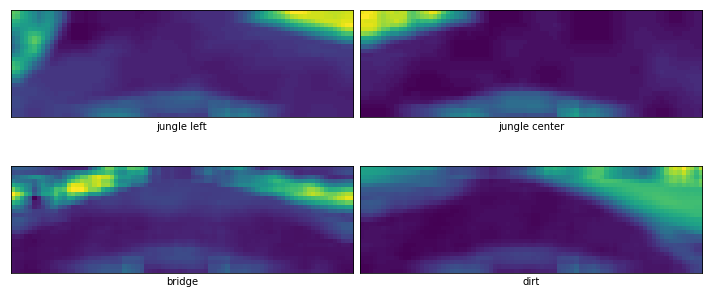

In [105]:
fig = plt.figure(figsize=(10,5))
axes = []

axis = fig.add_subplot(2,2,1)
axis.set_xlabel('jungle left')
plt.xticks(np.array([]))
plt.yticks(np.array([]))
axis.imshow(process_image(img1))

axis = fig.add_subplot(2,2,2)
axis.set_xlabel('jungle center')
plt.xticks(np.array([]))
plt.yticks(np.array([]))
axis.imshow(process_image(img2))

axis = fig.add_subplot(2,2,3)
axis.set_xlabel('bridge')
plt.xticks(np.array([]))
plt.yticks(np.array([]))
axis.imshow(process_image(img3))

axis = fig.add_subplot(2,2,4)
axis.set_xlabel('dirt')
plt.xticks(np.array([]))
plt.yticks(np.array([]))
axis.imshow(process_image(img4))

plt.tight_layout(h_pad=0, w_pad=0)
plt.show()


In [7]:
# Flipping images horizontally
# NOT DONE THIS TIME
for i in range(0, len(imgs)):
    image = cv2.imread(imgs[i], 0)
    name = './training/IMG/flip-' + imgs[i].split('/')[-1]

    flip = np.fliplr(image)
    cv2.imwrite(name, flip)
    
    imgs.append(name)
    angles.append(angles[i] * -1)

print (len(imgs), len(angles))

42876 42876


# Final Image Processing Pipeline

1. Resize 80:40
2. Crop 15-40, 0-80
2. Extract Saturation (S) channel from HSV transform of image
3. Blur, kernel 5
4. Normalize

#### Use a generator function to create batches while training
Copied and modified from Udacity lectures

Split into training and validation sets

In [8]:
samples = []
with open('driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

train_samples, validation_samples = train_test_split(samples, test_size=0.2)


In [17]:
def generator2(samples, batch_size=32):
    num_samples = len(samples)
    shuffle(samples)
    while 1: # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = './training/IMG/'+batch_sample[0].split('/')[-1]
                image = mpimg.imread(name)
                center_image = normalize(blur(hsv(image)[:,:,1], kernel_size=5))
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)

In [20]:
train_generator = generator2(train_samples, batch_size=32)
validation_generator = generator2(validation_samples, batch_size=32)

In [ ]:
print (next(train_generator))

### Plotting the Udacity dataset. It seems we need way more course correction data to balance the dataset.
It means I will try to record mainly edge cases and recovery. Then I will add the data from those new csv files to the existing Udacity dataset in the program. After that I'll plot a histogram again.

#### Creating the model

In [10]:
from keras.layers.pooling import MaxPooling1D

In [11]:
model = Sequential()
    
model.add(Convolution1D(64, 3, input_shape=(25, 80)))
model.add(Activation('relu'))
model.add(MaxPooling1D(2))

model.add(Flatten())

model.add(Dense(64))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')


In [ ]:
history = model.fit_generator(train_generator, samples_per_epoch=len(X_train), nb_epoch=5, verbose=1, validation_data=validgen, nb_val_samples=len(X_validation))

In [21]:
model.fit_generator(train_generator, samples_per_epoch=len(train_samples), validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=5)

Epoch 1/5
9486/9486 [==============================] - 89s - loss: 0.1463 - val_loss: 0.1412

In [22]:
model.save('model-tiny3.h5')